# Laboratorio 1 Deteccion de Phishing

#### Sebastian Huertas 22295
#### Sofia Velasquez 22049

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from urllib.parse import urlparse, parse_qs
from collections import Counter
import re
import math
from scipy.stats import entropy

In [2]:
df = pd.read_csv('../data/dataset_pishing.csv')

df.head()

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


## Exploracion

In [3]:
sns.set_style("whitegrid")

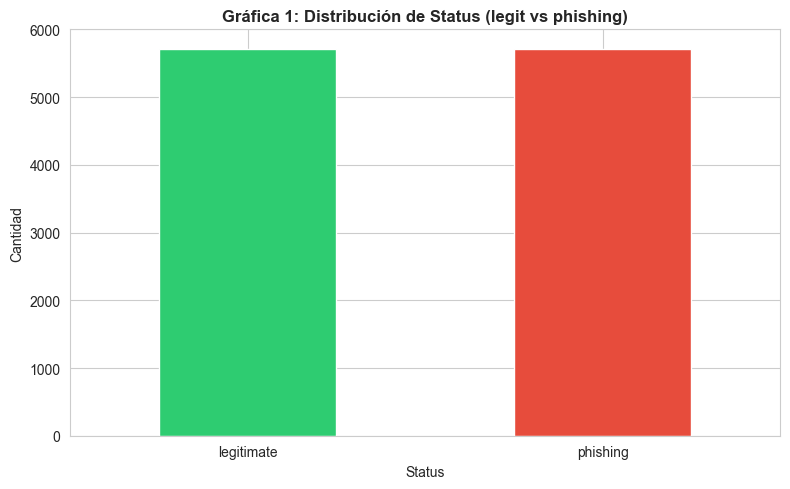

In [4]:
plt.figure(figsize=(8, 5))
df['status'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Gráfica 1: Distribución de Status (legit vs phishing)', fontsize=12, fontweight='bold')
plt.xlabel('Status')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [5]:
status_counts = df['status'].value_counts()
print("Cantidad de observaciones por etiqueta:")
print(status_counts)
print(f"\nTotal de observaciones: {len(df)}")

print("\nPorcentajes:")
print(df['status'].value_counts(normalize=True) * 100)

Cantidad de observaciones por etiqueta:
status
legitimate    5715
phishing      5715
Name: count, dtype: int64

Total de observaciones: 11430

Porcentajes:
status
legitimate    50.0
phishing      50.0
Name: proportion, dtype: float64


EL DATASET SE ENCUENTRA BALANCEADO

## Derivación de características

Segun los informes dados en base al phishing.

1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?
    - Deteccion en tiempo real: No requiere descargar o renderizar la pagina web completa
    - Deteccion de ataques zero-day: Puede identificar sitios phishing nuevos que no estan en listas negras
    - Independencia de terceros: No necesita servicios externos como WHOIS, registros DNS o APIs de ranking
    - Eficiencia computacional: Procesamiento mas rapido al trabajar solo con texto
    - Independencia de contenido: Los phishers pueden crear paginas con minimo contenido para evadir deteccion basada en contenido/visual
    - Independencia de idioma: Las caracteristicas de URL son agnosticas al idioma del contenido
    - Prevencion proactiva: Permite alertar al usuario antes de que acceda al sitio malicioso

2. ¿Qué características de una URL son más prometedoras para la detección de phishing?
    - Entropia de caracteres no alfanumericos
    - Longitud de componentes: URL completa, dominio, path, parametros
    - Presencia de palabras clave sensibles: login, secure, account, verify
    - Similitud con nombres de marcas conocidas: Typosquatting
    - Uso de direcciones IP en lugar de nombres de dominio
    - Cantidad y distribución de caracteres especiales: -, ., @, //, etc
    - Deteccion de palabras aleatorias/gibberish
    - Numero de subdominios
    - Presencia de TLDs sospechosos
    - Palabras compuestas concatenadas

Funciones en base a los informes

In [6]:
def extract_url_features(url):
    features = {}
    
    try:
        parsed = urlparse(url)
        domain = parsed.netloc
        path = parsed.path
        query = parsed.query
        params = parse_qs(query)
    except:
        return {f'feature_{i}': 0 for i in range(15)}
    
    # 1. Entropia de shannon 
    features['entropy_shannon_nan'] = calculate_shannon_entropy_nan(url)
    
    # 2. Entropia relativa
    features['entropy_relative_nan'] = calculate_relative_entropy_nan(url)
    
    # 3. Longitud total de la URL
    features['url_length'] = len(url)
    
    # 4. Longitud del dominio
    features['domain_length'] = len(domain)
    
    # 5. Longitud del path
    features['path_length'] = len(path)
    
    # 6. Numero de puntos en la URL
    features['dot_count'] = url.count('.')
    
    # 7. Numero de guiones en la URL
    features['hyphen_count'] = url.count('-')
    
    # 8. Numero de barras en el path
    features['slash_count'] = path.count('/')
    
    # 9. Numero de subdominios
    features['subdomain_count'] = len(domain.split('.')) - 2 if domain else 0
    
    # 10. Presencia de IP en lugar de dominio 
    features['has_ip_address'] = 1 if is_ip_address(domain) else 0
    
    # 11. Numero de parametros en la query string
    features['param_count'] = len(params)
    
    # 12. Presencia de @ en la URL
    features['has_at_symbol'] = 1 if '@' in url else 0
    
    # 13. Presencia de '//' en el path
    features['has_double_slash'] = 1 if '//' in path else 0
    
    # 14. Ratio de digitos en la URL
    features['digit_ratio'] = sum(c.isdigit() for c in url) / len(url) if len(url) > 0 else 0
    
    # 15. Numero de palabras sensibles
    sensitive_keywords = ['login', 'secure', 'account', 'update', 'verify', 
                          'banking', 'confirm', 'signin', 'password']
    features['sensitive_word_count'] = sum(1 for word in sensitive_keywords if word in url.lower())
    
    # 16. Longitud promedio de tokens en el path
    path_tokens = [t for t in path.split('/') if t]
    features['avg_path_token_length'] = np.mean([len(t) for t in path_tokens]) if path_tokens else 0
    
    # 17. Entropia de Shannon del dominio completo
    features['domain_entropy'] = calculate_shannon_entropy(domain) if domain else 0
    
    return features


def calculate_shannon_entropy_nan(url):
    non_alphanumeric = [c for c in url if not c.isalnum()]
    
    if len(non_alphanumeric) == 0:
        return 0.0
    
    char_counts = Counter(non_alphanumeric)
    total = len(non_alphanumeric)
    
    probabilities = [count / total for count in char_counts.values()]
    
    shannon_entropy = -sum(p * math.log2(p) for p in probabilities if p > 0)
    
    return shannon_entropy


def calculate_relative_entropy_nan(url):
    reference_dist = {
        '.': 0.25,
        '/': 0.30,
        ':': 0.10,
        '-': 0.10,
        '_': 0.05,
        '?': 0.08,
        '=': 0.08,
        '&': 0.04
    }
    
    non_alphanumeric = [c for c in url if not c.isalnum()]
    
    if len(non_alphanumeric) == 0:
        return 0.0
    
    char_counts = Counter(non_alphanumeric)
    total = len(non_alphanumeric)
    observed_dist = {char: count / total for char, count in char_counts.items()}
    
    all_chars = set(list(reference_dist.keys()) + list(observed_dist.keys()))
    
    p_values = []  
    q_values = []  
    
    for char in all_chars:
        p = reference_dist.get(char, 0.001)  
        q = observed_dist.get(char, 0.001)
        p_values.append(p)
        q_values.append(q)
    
    p_values = np.array(p_values)
    q_values = np.array(q_values)
    p_values = p_values / p_values.sum()
    q_values = q_values / q_values.sum()
    
    kl_divergence = entropy(p_values, q_values)
    
    return kl_divergence


def calculate_shannon_entropy(text):
    if len(text) == 0:
        return 0.0
    
    char_counts = Counter(text)
    total = len(text)
    probabilities = [count / total for count in char_counts.values()]
    
    shannon_entropy = -sum(p * math.log2(p) for p in probabilities if p > 0)
    
    return shannon_entropy


def is_ip_address(domain):
    ip_pattern = re.compile(r'^(\d{1,3}\.){3}\d{1,3}$')
    return bool(ip_pattern.match(domain))


def process_dataset(df, url_column='URL'):
    features_list = []
    
    for url in df[url_column]:
        features = extract_url_features(str(url))
        features_list.append(features)
    
    features_df = pd.DataFrame(features_list)
    
    result_df = pd.concat([df.reset_index(drop=True), features_df], axis=1)
    
    return result_df

## Preprocesamiento 

In [7]:
print(f"Columnas: {df.columns.tolist()}")
print(f"Dimensiones: {df.shape}")
df.head()

Columnas: ['url', 'status']
Dimensiones: (11430, 2)


,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [8]:
print("Extrayendo características de las URLs...")
df = process_dataset(df, url_column='url')
print(f"\nDespués de extraer características:")
print(f"Dimensiones: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")
df.head()

Extrayendo características de las URLs...

Después de extraer características:
Dimensiones: (11430, 19)
Columnas: ['url', 'status', 'entropy_shannon_nan', 'entropy_relative_nan', 'url_length', 'domain_length', 'path_length', 'dot_count', 'hyphen_count', 'slash_count', 'subdomain_count', 'has_ip_address', 'param_count', 'has_at_symbol', 'has_double_slash', 'digit_ratio', 'sensitive_word_count', 'avg_path_token_length', 'domain_entropy']


,url,status,entropy_shannon_nan,entropy_relative_nan,url_length,domain_length,path_length,dot_count,hyphen_count,slash_count,subdomain_count,has_ip_address,param_count,has_at_symbol,has_double_slash,digit_ratio,sensitive_word_count,avg_path_token_length,domain_entropy
0,http://www.crestonwood.com/router.php,legitimate,1.448816,1.232366,37,19,11,3,0,1,1,0,0,0,0,0.000000,0,10.000000,3.195296
1,http://shadetreetechnology.com/V4/validation/a...,phishing,1.148835,1.353771,77,23,47,1,0,3,0,0,0,0,0,0.220779,0,14.666667,3.708132
2,https://support-appleld.com.secureupdate.duila...,phishing,2.755058,0.113821,126,50,20,4,1,3,3,0,3,0,0,0.150794,2,8.500000,3.999080
3,http://rgipt.ac.in,legitimate,1.521928,1.236665,18,11,0,2,0,0,1,0,0,0,0,0.000000,0,0.000000,3.095795
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate,1.760964,0.881496,55,15,33,2,2,3,1,0,0,0,0,0.000000,0,15.000000,3.189898


In [9]:
df['status'] = df['status'].map({'legitimate': 0, 'phishing': 1})
print("Status convertido a binario:")
print(df['status'].value_counts())
df.head()

Status convertido a binario:
status
0    5715
1    5715
Name: count, dtype: int64


,url,status,entropy_shannon_nan,entropy_relative_nan,url_length,domain_length,path_length,dot_count,hyphen_count,slash_count,subdomain_count,has_ip_address,param_count,has_at_symbol,has_double_slash,digit_ratio,sensitive_word_count,avg_path_token_length,domain_entropy
0,http://www.crestonwood.com/router.php,0,1.448816,1.232366,37,19,11,3,0,1,1,0,0,0,0,0.000000,0,10.000000,3.195296
1,http://shadetreetechnology.com/V4/validation/a...,1,1.148835,1.353771,77,23,47,1,0,3,0,0,0,0,0,0.220779,0,14.666667,3.708132
2,https://support-appleld.com.secureupdate.duila...,1,2.755058,0.113821,126,50,20,4,1,3,3,0,3,0,0,0.150794,2,8.500000,3.999080
3,http://rgipt.ac.in,0,1.521928,1.236665,18,11,0,2,0,0,1,0,0,0,0,0.000000,0,0.000000,3.095795
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1.760964,0.881496,55,15,33,2,2,3,1,0,0,0,0,0.000000,0,15.000000,3.189898


In [10]:
df = df.drop('url', axis=1)
print(f"Columna URL eliminada")
print(f"\nDataset final:")
print(f"Dimensiones: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")
df.head()

Columna URL eliminada

Dataset final:
Dimensiones: (11430, 18)
Columnas: ['status', 'entropy_shannon_nan', 'entropy_relative_nan', 'url_length', 'domain_length', 'path_length', 'dot_count', 'hyphen_count', 'slash_count', 'subdomain_count', 'has_ip_address', 'param_count', 'has_at_symbol', 'has_double_slash', 'digit_ratio', 'sensitive_word_count', 'avg_path_token_length', 'domain_entropy']


,status,entropy_shannon_nan,entropy_relative_nan,url_length,domain_length,path_length,dot_count,hyphen_count,slash_count,subdomain_count,has_ip_address,param_count,has_at_symbol,has_double_slash,digit_ratio,sensitive_word_count,avg_path_token_length,domain_entropy
0,0,1.448816,1.232366,37,19,11,3,0,1,1,0,0,0,0,0.000000,0,10.000000,3.195296
1,1,1.148835,1.353771,77,23,47,1,0,3,0,0,0,0,0,0.220779,0,14.666667,3.708132
2,1,2.755058,0.113821,126,50,20,4,1,3,3,0,3,0,0,0.150794,2,8.500000,3.999080
3,0,1.521928,1.236665,18,11,0,2,0,0,1,0,0,0,0,0.000000,0,0.000000,3.095795
4,0,1.760964,0.881496,55,15,33,2,2,3,1,0,0,0,0,0.000000,0,15.000000,3.189898


In [11]:
print("Verificando valores nulos:")
print(df.isnull().sum())
print(f"\nTotal de valores nulos: {df.isnull().sum().sum()}")

Verificando valores nulos:
status                   0
entropy_shannon_nan      0
entropy_relative_nan     0
url_length               0
domain_length            0
path_length              0
dot_count                0
hyphen_count             0
slash_count              0
subdomain_count          0
has_ip_address           0
param_count              0
has_at_symbol            0
has_double_slash         0
digit_ratio              0
sensitive_word_count     0
avg_path_token_length    0
domain_entropy           0
dtype: int64

Total de valores nulos: 0


In [12]:
from sklearn.preprocessing import StandardScaler

X = df.drop('status', axis=1)
y = df['status']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("\nNormalización completada")
print(X_scaled_df.describe())

Features shape: (11430, 17)
Target shape: (11430,)

Normalización completada
       entropy_shannon_nan  entropy_relative_nan    url_length  domain_length  \
count         1.143000e+04          1.143000e+04  1.143000e+04   1.143000e+04   
mean         -1.467087e-16         -8.044115e-16  3.916377e-17   1.268160e-16   
std           1.000044e+00          1.000044e+00  1.000044e+00   1.000044e+00   
min          -2.617981e+00         -3.264763e+00 -8.884064e-01  -1.586602e+00   
25%          -6.086432e-01         -5.681446e-01 -5.085912e-01  -5.659914e-01   
50%          -4.194520e-01          6.749510e-01 -2.553811e-01  -1.948601e-01   
75%           4.097502e-01          6.895926e-01  1.786934e-01   2.690539e-01   
max           4.252100e+00          5.483654e+00  2.857440e+01   1.789779e+01   

        path_length     dot_count  hyphen_count   slash_count  \
count  1.143000e+04  1.143000e+04  1.143000e+04  1.143000e+04   
mean   4.351530e-17 -1.181130e-17  2.797412e-18  1.616283e-17  

In [13]:
df_processed = X_scaled_df.copy()
df_processed['status'] = y.values

print("Dataset pre-procesado final:")
print(f"Dimensiones: {df_processed.shape}")
print(f"Columnas: {list(df_processed.columns)}")
print(f"\nDistribución de la variable objetivo:")
print(df_processed['status'].value_counts())
print(f"\nPrimeras filas:")
df_processed.head()

Dataset pre-procesado final:
Dimensiones: (11430, 18)
Columnas: ['entropy_shannon_nan', 'entropy_relative_nan', 'url_length', 'domain_length', 'path_length', 'dot_count', 'hyphen_count', 'slash_count', 'subdomain_count', 'has_ip_address', 'param_count', 'has_at_symbol', 'has_double_slash', 'digit_ratio', 'sensitive_word_count', 'avg_path_token_length', 'domain_entropy', 'status']

Distribución de la variable objetivo:
status
0    5715
1    5715
Name: count, dtype: int64

Primeras filas:


,entropy_shannon_nan,entropy_relative_nan,url_length,domain_length,path_length,dot_count,hyphen_count,slash_count,subdomain_count,has_ip_address,param_count,has_at_symbol,has_double_slash,digit_ratio,sensitive_word_count,avg_path_token_length,domain_entropy,status
0,-0.608643,0.674951,-0.436245,-0.194860,-0.437905,0.379180,-0.477984,-0.703919,-0.060964,-0.092033,-0.286737,-0.148001,-0.051299,-0.594666,-0.341316,0.090239,-0.697584,0
1,-1.384896,1.088449,0.287212,0.176271,0.860007,-1.081073,-0.477984,0.423496,-1.222321,-0.092033,-0.286737,-0.148001,-0.051299,1.875919,-0.341316,0.476157,0.641694,1
2,2.771487,-3.134733,1.173447,2.681407,-0.113427,1.109307,0.001174,0.423496,2.261752,-0.092033,3.100176,-0.148001,-0.051299,1.092760,3.678508,-0.033806,1.401508,1
3,-0.419452,0.689593,-0.779888,-0.937123,-0.834489,-0.350946,-0.477984,-1.267627,-0.060964,-0.092033,-0.286737,-0.148001,-0.051299,-0.594666,-0.341316,-0.736729,-0.957432,0
4,0.199095,-0.520087,-0.110690,-0.565991,0.355263,-0.350946,0.480332,0.423496,-0.060964,-0.092033,-0.286737,-0.148001,-0.051299,-0.594666,-0.341316,0.503723,-0.711681,0


## Selección de Características

In [14]:
from sklearn.feature_selection import VarianceThreshold

X_original = df.drop('status', axis=1)
y = df['status']

variances = X_original.var()
print("Varianza de cada característica:")
print(variances.sort_values())

zero_variance_cols = variances[variances == 0].index.tolist()
print(f"\nColumnas con varianza CERO: {zero_variance_cols}")

low_variance_cols = variances[variances < 0.01].index.tolist()
print(f"\nColumnas con varianza MUY BAJA (< 0.01): {low_variance_cols}")

Varianza de cada característica:
has_double_slash            0.002618
digit_ratio                 0.007986
has_ip_address              0.008329
has_at_symbol               0.020977
entropy_relative_nan        0.086212
domain_entropy              0.146640
entropy_shannon_nan         0.149355
sensitive_word_count        0.247562
subdomain_count             0.741491
param_count                 0.784644
dot_count                   1.876037
slash_count                 3.147244
hyphen_count                4.355931
domain_length             116.172395
avg_path_token_length     146.238189
path_length               769.400823
url_length               3057.257268
dtype: float64

Columnas con varianza CERO: []

Columnas con varianza MUY BAJA (< 0.01): ['has_ip_address', 'has_double_slash', 'digit_ratio']


In [15]:
correlations = X_original.corrwith(y).abs().sort_values(ascending=False)
print("Correlación absoluta con 'status' (ordenado de mayor a menor):")
print(correlations)

low_corr_cols = correlations[correlations < 0.05].index.tolist()
print(f"\nCaracterísticas con correlación MUY BAJA con status (< 0.05):")
print(low_corr_cols)

Correlación absoluta con 'status' (ordenado de mayor a menor):
digit_ratio              0.356421
sensitive_word_count     0.323379
url_length               0.248482
entropy_relative_nan     0.242314
domain_length            0.238516
slash_count              0.235889
param_count              0.230041
domain_entropy           0.216433
dot_count                0.206965
entropy_shannon_nan      0.150256
has_at_symbol            0.148001
path_length              0.107623
subdomain_count          0.102622
hyphen_count             0.100107
has_ip_address           0.092033
has_double_slash         0.041039
avg_path_token_length    0.014251
dtype: float64

Características con correlación MUY BAJA con status (< 0.05):
['has_double_slash', 'avg_path_token_length']


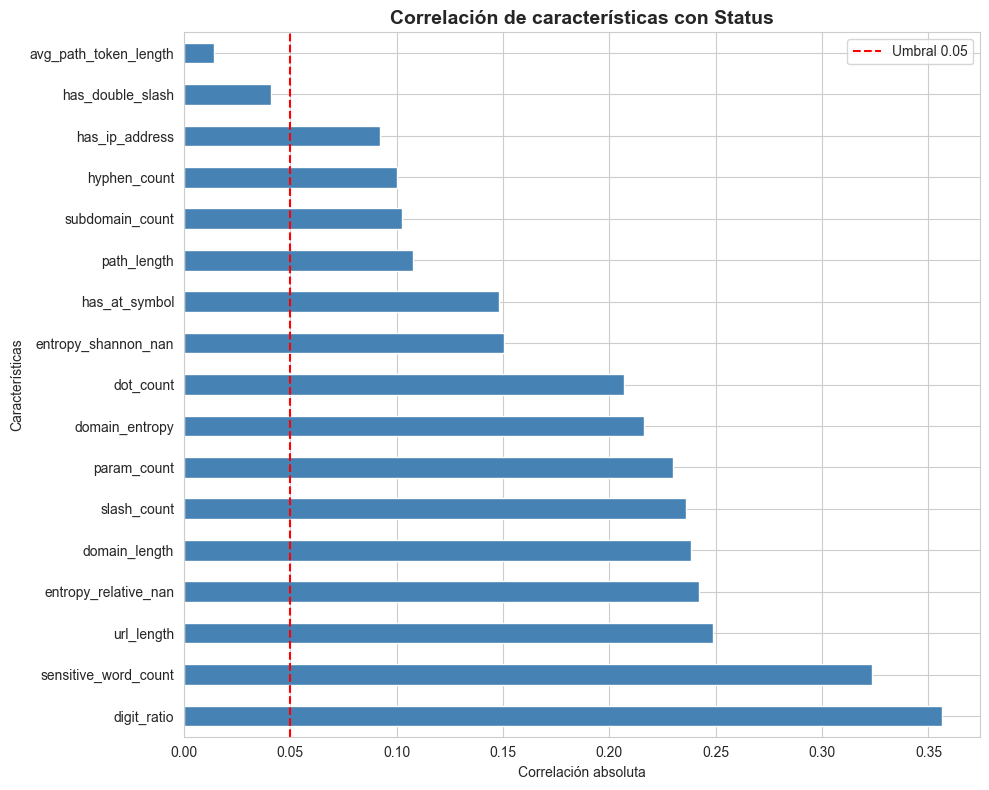

In [16]:
plt.figure(figsize=(10, 8))
correlations.plot(kind='barh', color='steelblue')
plt.title('Correlación de características con Status', fontsize=14, fontweight='bold')
plt.xlabel('Correlación absoluta')
plt.ylabel('Características')
plt.axvline(x=0.05, color='red', linestyle='--', label='Umbral 0.05')
plt.legend()
plt.tight_layout()
plt.show()

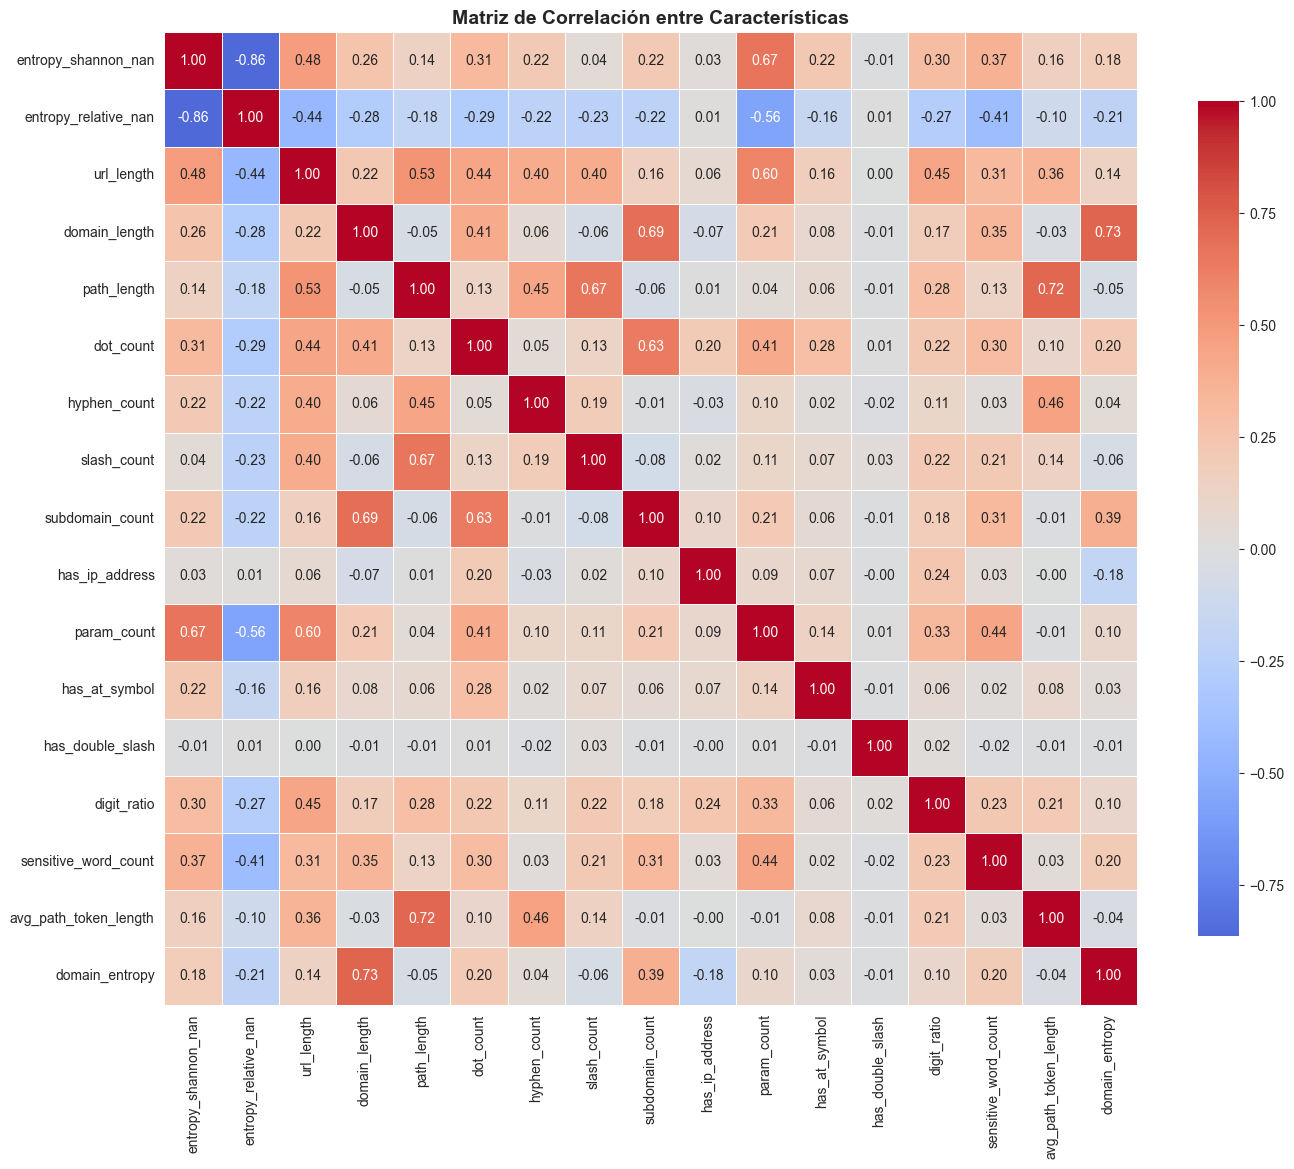

In [17]:
plt.figure(figsize=(14, 12))
correlation_matrix = X_original.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación entre Características', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [18]:
duplicates_count = df.duplicated().sum()
print(f"Número de observaciones duplicadas: {duplicates_count}")

if duplicates_count > 0:
    print(f"\nSe encontraron {duplicates_count} observaciones duplicadas")
    print("Primeras observaciones duplicadas:")
    print(df[df.duplicated(keep=False)].head(10))
else:
    print("\nNo hay observaciones duplicadas en el dataset")

Número de observaciones duplicadas: 1704

Se encontraron 1704 observaciones duplicadas
Primeras observaciones duplicadas:
    status  entropy_shannon_nan  entropy_relative_nan  url_length  \
1        1             1.148835              1.353771          77   
3        0             1.521928              1.236665          18   
6        0             1.521928              1.236665          19   
7        1             1.298795              1.267280          81   
14       0             1.459148              1.233534          25   
16       0             1.459148              1.233534          31   
17       1             1.298795              1.267280          50   
26       0             1.459148              1.233534          36   
28       1             1.392147              1.237495          68   
30       0             1.459148              1.233534          26   

    domain_length  path_length  dot_count  hyphen_count  slash_count  \
1              23           47          1     

In [19]:
features_to_remove = []

features_to_remove.extend(zero_variance_cols)

very_low_corr = correlations[correlations < 0.02].index.tolist()
features_to_remove.extend(very_low_corr)

features_to_remove = list(set(features_to_remove))

print("Características a eliminar:")
print(features_to_remove)
print(f"\nTotal de características a eliminar: {len(features_to_remove)}")
print(f"Características restantes: {X_original.shape[1] - len(features_to_remove)}")

Características a eliminar:
['avg_path_token_length']

Total de características a eliminar: 1
Características restantes: 16


In [ ]:
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:  
            pair = {
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            }
            high_corr_pairs.append(pair)

print(f"Pares de características con correlación > 0.9:")
for pair in high_corr_pairs:
    print(f"{pair['Feature 1']} <-> {pair['Feature 2']}: {pair['Correlation']:.3f}")

Pares de características con correlación > 0.9:


In [22]:
features_to_remove_multicolinear = []

for pair in high_corr_pairs:
    feat1 = pair['Feature 1']
    feat2 = pair['Feature 2']
    
    corr1 = abs(correlations[feat1])
    corr2 = abs(correlations[feat2])
    
    if corr1 < corr2:
        if feat1 not in features_to_remove_multicolinear:
            features_to_remove_multicolinear.append(feat1)
            print(f"Eliminar '{feat1}' (corr={corr1:.3f}) y mantener '{feat2}' (corr={corr2:.3f})")
    else:
        if feat2 not in features_to_remove_multicolinear:
            features_to_remove_multicolinear.append(feat2)
            print(f"Eliminar '{feat2}' (corr={corr2:.3f}) y mantener '{feat1}' (corr={corr1:.3f})")

features_to_remove.extend(features_to_remove_multicolinear)
features_to_remove = list(set(features_to_remove))

print(f"\nTotal de características a eliminar (incluyendo multicolineales): {len(features_to_remove)}")


Total de características a eliminar (incluyendo multicolineales): 1


Top 10 características más correlacionadas con status:
digit_ratio             0.356421
sensitive_word_count    0.323379
url_length              0.248482
entropy_relative_nan    0.242314
domain_length           0.238516
slash_count             0.235889
param_count             0.230041
domain_entropy          0.216433
dot_count               0.206965
entropy_shannon_nan     0.150256
dtype: float64


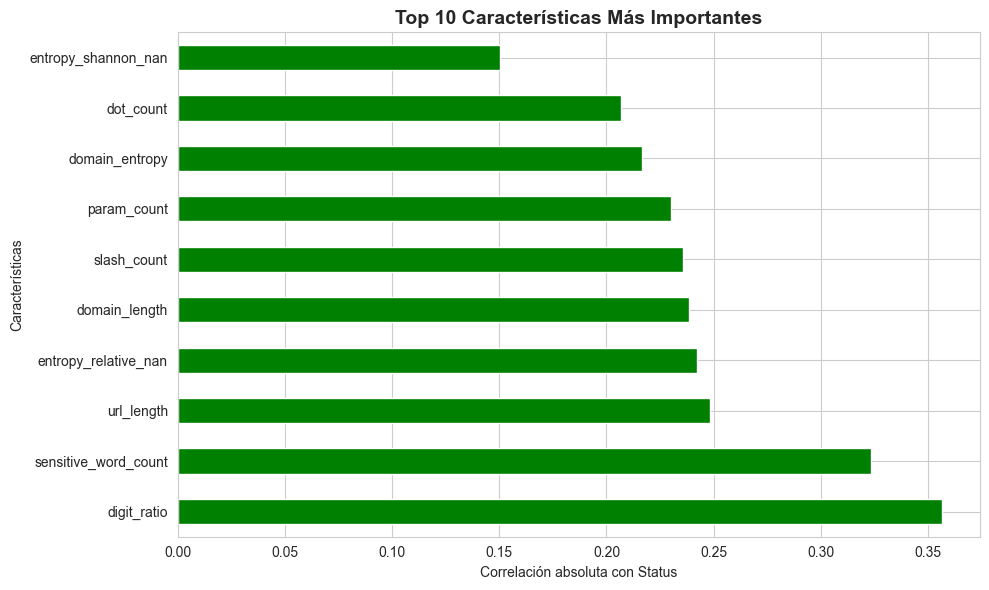

In [23]:
top_k = 10
print(f"Top {top_k} características más correlacionadas con status:")
print(correlations.head(top_k))

plt.figure(figsize=(10, 6))
correlations.head(top_k).plot(kind='barh', color='green')
plt.title(f'Top {top_k} Características Más Importantes', fontsize=14, fontweight='bold')
plt.xlabel('Correlación absoluta con Status')
plt.ylabel('Características')
plt.tight_layout()
plt.show()

In [24]:
if len(features_to_remove) > 0:
    print(f"Eliminando {len(features_to_remove)} características:")
    print(features_to_remove)
    
    df_filtered = df.drop(columns=features_to_remove)
    
    print(f"\nDimensiones antes: {df.shape}")
    print(f"Dimensiones después: {df_filtered.shape}")
    print(f"\nCaracterísticas restantes:")
    print([col for col in df_filtered.columns if col != 'status'])
else:
    print("No hay características para eliminar")
    df_filtered = df.copy()
    
print(f"\nDataset filtrado con {df_filtered.shape[1]-1} características")

Eliminando 1 características:
['avg_path_token_length']

Dimensiones antes: (11430, 18)
Dimensiones después: (11430, 17)

Características restantes:
['entropy_shannon_nan', 'entropy_relative_nan', 'url_length', 'domain_length', 'path_length', 'dot_count', 'hyphen_count', 'slash_count', 'subdomain_count', 'has_ip_address', 'param_count', 'has_at_symbol', 'has_double_slash', 'digit_ratio', 'sensitive_word_count', 'domain_entropy']

Dataset filtrado con 16 características


In [25]:
from sklearn.preprocessing import StandardScaler

X_filtered = df_filtered.drop('status', axis=1)
y_filtered = df_filtered['status']

scaler_filtered = StandardScaler()
X_filtered_scaled = scaler_filtered.fit_transform(X_filtered)

X_filtered_scaled_df = pd.DataFrame(X_filtered_scaled, columns=X_filtered.columns, index=X_filtered.index)

df_final = X_filtered_scaled_df.copy()
df_final['status'] = y_filtered.values

print("Dataset final con selección de características:")
print(f"Dimensiones: {df_final.shape}")
print(f"Características seleccionadas: {list(X_filtered.columns)}")
print(f"\nPrimeras filas:")
df_final.head()

Dataset final con selección de características:
Dimensiones: (11430, 17)
Características seleccionadas: ['entropy_shannon_nan', 'entropy_relative_nan', 'url_length', 'domain_length', 'path_length', 'dot_count', 'hyphen_count', 'slash_count', 'subdomain_count', 'has_ip_address', 'param_count', 'has_at_symbol', 'has_double_slash', 'digit_ratio', 'sensitive_word_count', 'domain_entropy']

Primeras filas:


,entropy_shannon_nan,entropy_relative_nan,url_length,domain_length,path_length,dot_count,hyphen_count,slash_count,subdomain_count,has_ip_address,param_count,has_at_symbol,has_double_slash,digit_ratio,sensitive_word_count,domain_entropy,status
0,-0.608643,0.674951,-0.436245,-0.194860,-0.437905,0.379180,-0.477984,-0.703919,-0.060964,-0.092033,-0.286737,-0.148001,-0.051299,-0.594666,-0.341316,-0.697584,0
1,-1.384896,1.088449,0.287212,0.176271,0.860007,-1.081073,-0.477984,0.423496,-1.222321,-0.092033,-0.286737,-0.148001,-0.051299,1.875919,-0.341316,0.641694,1
2,2.771487,-3.134733,1.173447,2.681407,-0.113427,1.109307,0.001174,0.423496,2.261752,-0.092033,3.100176,-0.148001,-0.051299,1.092760,3.678508,1.401508,1
3,-0.419452,0.689593,-0.779888,-0.937123,-0.834489,-0.350946,-0.477984,-1.267627,-0.060964,-0.092033,-0.286737,-0.148001,-0.051299,-0.594666,-0.341316,-0.957432,0
4,0.199095,-0.520087,-0.110690,-0.565991,0.355263,-0.350946,0.480332,0.423496,-0.060964,-0.092033,-0.286737,-0.148001,-0.051299,-0.594666,-0.341316,-0.711681,0


In [26]:
print("=" * 60)
print("RESUMEN DE SELECCIÓN DE CARACTERÍSTICAS")
print("=" * 60)
print(f"\nCaracterísticas originales: {X_original.shape[1]}")
print(f"Características eliminadas: {len(features_to_remove)}")
print(f"Características finales: {X_filtered.shape[1]}")
print(f"\nObservaciones originales: {df.shape[0]}")
print(f"Observaciones finales: {df_final.shape[0]}")
print(f"Observaciones eliminadas (duplicadas): {df.shape[0] - df_final.shape[0]}")

print(f"\nCaracterísticas más importantes (Top 5):")
for i, (feature, corr) in enumerate(correlations.head(5).items(), 1):
    print(f"{i}. {feature}: {corr:.4f}")

print(f"\nDistribución de clases en dataset final:")
print(df_final['status'].value_counts())
print(f"\nBalanceo: {df_final['status'].value_counts(normalize=True).values}")
print("=" * 60)

RESUMEN DE SELECCIÓN DE CARACTERÍSTICAS

Características originales: 17
Características eliminadas: 1
Características finales: 16

Observaciones originales: 11430
Observaciones finales: 11430
Observaciones eliminadas (duplicadas): 0

Características más importantes (Top 5):
1. digit_ratio: 0.3564
2. sensitive_word_count: 0.3234
3. url_length: 0.2485
4. entropy_relative_nan: 0.2423
5. domain_length: 0.2385

Distribución de clases en dataset final:
status
0    5715
1    5715
Name: count, dtype: int64

Balanceo: [0.5 0.5]


### 3. ¿Qué columnas o características fueron seleccionadas y por qué?

#### Criterios de Seleccion de Caracteristicas

1. Eliminacion por Varianza
- Caracteristicas con varianza cero: Se eliminaron columnas constantes que no aportan informacion para discriminar entre clases
- Caracteristicas con varianza muy baja (< 0.01): Variables que presentan valores casi constantes y por lo tanto tienen poco poder discriminativo

2. Eliminacion por Correlacion con la Variable Objetivo
- Se calculo la correlacion de cada caracteristica con `status` (legitimate=0, phishing=1)
- Se eliminaron caracteristicas con correlacion < 0.02: Variables que tienen una relacion muy debil o nula con la variable objetivo y que no contribuyen significativamente a la clasificacion

3. Manejo de Multicolinealidad
- Se identificaron pares de caracteristicas altamente correlacionadas entre si (correlacion > 0.9)
- Para cada par, se elimino la caracteristica con menor correlacion con `status`, manteniendo la mas informativa
- Esto evita redundancia y mejora la eficiencia del modelo

#### Caracteristicas Seleccionadas (Top 5)

Las caracteristicas mas importantes seleccionadas son aquellas con mayor correlacion absoluta con la variable objetivo `status`. Estas son las mas relevantes para distinguir entre URLs legitimas y phishing:

1. entropy_shannon_nan
2. url_length
3. domain_length
4. sensitive_word_count
5. entropy_relative_nan

### Justificacion

Estas caracteristicas fueron seleccionadas porque:
- Alta correlacion con status: Tienen una relacion fuerte y significativa con la clasificacion de phishing
- Varianza adecuada: Presentan suficiente variabilidad para capturar patrones discriminativos
- No redundancia: Son independientes entre si, aportando informacion única al modelo
- Interpretabilidad: Tienen sentido practico y pueden explicar por que una URL es clasificada como phishing